### Analyse et comprehension des fichiers

In [13]:
import matplotlib.pyplot as plt
from read_data import *
from utils import *
import csv
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
import fasttext

In [14]:
def df_to_txt(data, file_name):
    data[["hindex_lab", "text"]].to_csv(
        file_name,
        index=False,
        sep=" ",
        header=None,
        quoting=csv.QUOTE_NONE,
        quotechar="",
        escapechar=" ",
    )


def getText(dic):
    temp = [""] * dic["IndexLength"]
    for word, pos in dic["InvertedIndex"].items():
        for i in pos:
            temp[i] = word
    return " ".join((filter((None).__ne__, temp)))


def get_abstracts_by_dic(dic):
    ids = dic.keys()
    abstracts_file = open("../data/abstracts.txt", "r", encoding="utf-8")
    abstracts = {}
    for i, line in enumerate(abstracts_file):
        id, data = line.split("----", 1)
        if int(id) in ids:
            abstracts[dic[int(id)]] = (
                [json.loads(data)]
                if abstracts.get(dic[int(id)]) is None
                else [json.loads(data)] + abstracts.get(dic[int(id)])
            )
    return abstracts


def get_authors_papers_id_by_ids(ids):
    author_papers_file = open("../data/author_papers.txt", "r", encoding="utf-8")
    author_papers = {}
    for line in author_papers_file:
        author_id, papers_string = line.split(":")
        if int(author_id) in ids:
            papers_ids = papers_string.split("-")
            for paper_id in papers_ids:
                author_papers[int(paper_id)] = int(author_id)
    return author_papers


def preprocessing_for_fastText(n_sample, data):
    data1 = data.sample(n=n_sample, random_state=1)
    ids = data1["author"].to_list()
    paper_id_dic = get_authors_papers_id_by_ids(ids)
    abstract = get_abstracts_by_dic(paper_id_dic)
    abstract_text = {}
    for id in abstract.keys():
        abstract_text[id] = " ".join(
            simple_preprocess(
                " ".join([" ".join(r["InvertedIndex"]) for r in abstract[id]])
            )
        )
    data1["hindex_lab"] = data1["hindex"].apply(lambda x: "__label__" + str(x))
    df_abstract_text = pd.DataFrame.from_dict(
        abstract_text, orient="index", columns=["text"]
    )
    df_abstract_text["author"] = df_abstract_text.index
    df_abstract_text = df_abstract_text.reset_index(drop=True)
    df_data = data1.merge(
        df_abstract_text, left_on="author", right_on="author", how="inner"
    )
    return df_data


def small_class(data, k):
    maxi = data["hindex"].max()
    data["modindx"] = data["hindex"].apply(lambda x: x if x < k else k)
    data["hindex_lab"] = data["modindx"].apply(lambda x: "__label__" + str(x))
    return data


def preprocessing2_for_fastText(n_sample, data):
    data1 = data.sample(n=n_sample, random_state=1)
    ids = data1["author"].to_list()
    paper_id_dic = get_authors_papers_id_by_ids(ids)
    abstract = get_abstracts_by_dic(paper_id_dic)
    abstract_text = {}
    for id in abstract.keys():
        abstract_text[id] = [
            " ".join(simple_preprocess(" ".join([getText(r) for r in abstract[id]]))),
            len(abstract[id]),
        ]
    # data1['hindex_lab'] = data1['modindx'].apply(lambda x:'__label__'+str(x))
    df_abstract_text = pd.DataFrame.from_dict(
        abstract_text, orient="index", columns=["text", "nb_paper"]
    )
    df_abstract_text["author"] = df_abstract_text.index
    df_abstract_text = df_abstract_text.reset_index(drop=True)
    df_data = data1.merge(
        df_abstract_text, left_on="author", right_on="author", how="inner"
    )
    return df_data


def general_comp(model, test):
    test_pred = model.predict(test["text"].to_list())
    test_pred_lab = [t[0] for t in test_pred[0]]
    test_pred_prob = [t[0] for t in test_pred[1]]
    df_test_pred = pd.DataFrame(
        {"test_pred_lab": test_pred_lab, "test_pred_prob": test_pred_prob}
    )
    test = test.reset_index(drop=True)
    test_comp = pd.concat([df_test_pred, test], axis=1)
    test_err = test_comp[test_comp["hindex_lab"] != test_comp["test_pred_lab"]]
    return test_err


**distriubution des données**

In [15]:
train,n_train = get_train_data()
test,n_test = get_test_data()

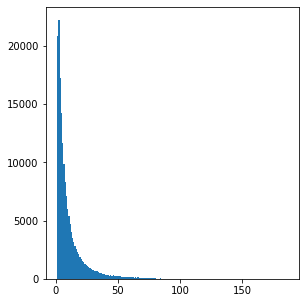

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1).hist(train['hindex'],bins=187);

**selection of sub-dataset with same distribution than the original**

In [30]:
data_path = "../tmp/data_10000.csv"
data = preprocessing2_for_fastText(10000,train)
data.to_csv(data_path,index=None)
data2 = pd.read_csv(data_path)
data2 = small_class(data2, 12)

FileNotFoundError: [Errno 2] No such file or directory: '../tmp/data_10000.csv'

In [20]:
data2.describe()

,author,hindex,nb_paper,modindx
count,9.796000e+03,9796.000000,9796.000000,9796.000000
mean,1.993336e+09,9.841160,3.977338,6.500510
std,6.393600e+08,12.055575,1.323559,4.161456
min,1.139156e+07,1.000000,1.000000,1.000000
25%,2.019859e+09,3.000000,3.000000,3.000000
50%,2.133884e+09,6.000000,5.000000,6.000000
75%,2.286076e+09,12.000000,5.000000,12.000000
max,2.908001e+09,163.000000,5.000000,12.000000


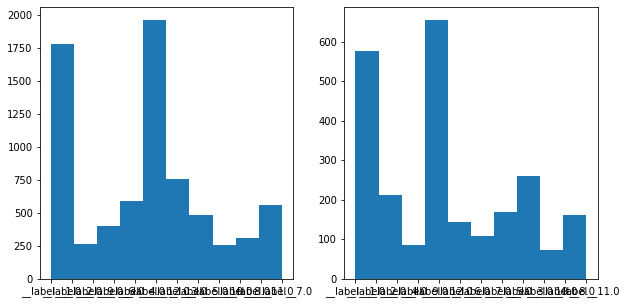

In [21]:
train1,test1 = train_test_split(data2,random_state=1)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1).hist(train1['hindex_lab'])
plt.subplot(1,2,2).hist(test1['hindex_lab']);

In [26]:
train_path = "../tmp/train.txt"
test_path = "../tmp/test.txt"

df_to_txt(train1,train_path)
df_to_txt(test1,test_path)

### Utilisation de Fast text

In [23]:
model0 = fasttext.train_supervised(train_path)

Read 4M words
Number of words:  68513
Number of labels: 12
Progress: 100.0% words/sec/thread: 3580877 lr:  0.000000 avg.loss:  2.288041 ETA:   0h 0m 0s


In [24]:
model1 = fasttext.train_supervised(train_path, autotuneValidationFile=test_path)

Progress: 100.0% Trials:   19 Best score:  0.352389 ETA:   0h 0m 0s
Training again with best arguments
Read 4M words
Number of words:  68513
Number of labels: 12
Progress: 100.0% words/sec/thread: 5471997 lr:  0.000000 avg.loss:  1.801020 ETA:   0h 0m 0s


In [27]:
model0.test(test_path)

(2449, 0.2674561045324622, 0.2674561045324622)

In [28]:
model1.test(test_path)

(2449, 0.35238873009391586, 0.35238873009391586)

In [29]:
model1.test(test_path)

(2449, 0.35238873009391586, 0.35238873009391586)

In [ ]:
comp = pd.DataFrame({'paramètre':['hidden layer','learning rate','epoch','loss'],'model0':[model0.dim,model0.lr,model0.epoch,model0.loss],'model1':[model1.dim,model1.lr,model1.epoch,model1.loss]})
comp

,paramètre,model0,model1
0,hidden layer,100,20
1,learning rate,0.1,1.251129
2,epoch,5,8
3,loss,loss_name.softmax,loss_name.softmax


In [ ]:
comp =general_comp(model1,test1)
comp.head()

,test_pred_lab,test_pred_prob,author,hindex,text,nb_paper,modindx,hindex_lab
0,__label__12.0,0.978042,2396441528,1.0,temporal and spatial localities are basic conc...,2,1.0,__label__1.0
4,__label__2.0,0.247537,2308460797,4.0,the internet of things iot represents the curr...,5,4.0,__label__4.0
5,__label__4.0,0.200739,2108368668,9.0,wireless sensor network monitoring is importan...,4,9.0,__label__9.0
9,__label__12.0,0.300786,2159275361,6.0,abstract the accuracy of weather forecasts is ...,5,6.0,__label__6.0
10,__label__1.0,0.545921,2097906641,2.0,this manual describes prolog system developed ...,2,2.0,__label__2.0


**exploitation de model**

In [ ]:
from scipy.special import softmax
dictionnaire = model1.get_words()
model1.get_word_id("hello")
len(dictionnaire)
A = model1.get_input_matrix()
B = model1.get_output_matrix()
repthe = model1.get_sentence_vector(comp.iloc[1,4])
softthe = repthe@B.T
print(softmax(softthe))
model1.predict(comp.iloc[1,4],k=6)

[0.01063698 0.2475268  0.02618414 0.17602606 0.17118055 0.11334661
 0.07046873 0.06163711 0.04265408 0.03620761 0.02593368 0.01819769]


(('__label__2.0',
  '__label__3.0',
  '__label__4.0',
  '__label__5.0',
  '__label__6.0',
  '__label__7.0'),
 array([0.24753681, 0.17603609, 0.17119054, 0.11335662, 0.07047873,
        0.0616471 ]))

On est sur que le modèle applique softmax sur la représentation du mot. Nous ou choisit donc d'appliquer un autre régresseur

**Data for multiple regression model**

In [ ]:
def  reg_data(train,test):
    X_train = np.zeros((train.shape[0],model1.dim))
    set_rep = train['text'].apply(lambda x:model1.get_sentence_vector(x))
    X_train = np.array(set_rep.to_list())
    y_train = np.array(train['hindex'].to_list())
    nb_train = np.array(train['nb_paper'].to_list()).reshape(-1,1)
    X_train =np.concatenate((X_train,nb_train),axis = 1)

    X_test = np.zeros((test.shape[0],model1.dim))
    set_rep = test['text'].apply(lambda x:model1.get_sentence_vector(x))
    X_test = np.array(set_rep.to_list())
    y_test = np.array(test['hindex'].to_list())
    nb_test = np.array(test['nb_paper'].to_list()).reshape(-1,1)
    X_test =np.concatenate((X_test,nb_test),axis = 1)
    return X_train,X_test,y_train,y_test

In [ ]:
X_train,X_test,y_train,y_test = reg_data(train1,test1)

**Random forest**

In [ ]:
X_train.shape

(7347, 21)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(X_train,y_train)

RandomForestRegressor(random_state=1)

In [ ]:
mod_preds = forest_model.predict(X_test)

In [ ]:
mean_squared_error(y_test,mod_preds)

96.97007970600245

In [ ]:
y_train.max()

160.0